In [1]:
from medmnist import PneumoniaMNIST
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

2024-01-02 18:52:05.807162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_train = PneumoniaMNIST(split='train', download=True)
dataset_test = PneumoniaMNIST(split='test', download=True)
dataset_val = PneumoniaMNIST(split='val', download=True)

Using downloaded and verified file: /Users/ramx/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/ramx/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/ramx/.medmnist/pneumoniamnist.npz


#### Exploring the data:
- The dataset is already separated in training, validation and testing subsets
- Each data point consists of a tuple of the image and the label

In [3]:
print("Dataset lengths, train:{} - test:{} - val:{}".format(len(dataset_train), len(dataset_test), len(dataset_val)))
print("Shape and type of each object: {}, {}".format(len(dataset_train[0]), type(dataset_train[0])))
print("Shape and type of image: {}, {}".format(np.array(dataset_train[0][0]).shape, type(dataset_train[0][0])))
print("Shape and type of label: {}, {}".format(dataset_train[0][1].shape, type(dataset_train[0][1])))

Dataset lengths, train:4708 - test:624 - val:524
Shape and type of each object: 2, <class 'tuple'>
Shape and type of image: (28, 28), <class 'PIL.Image.Image'>
Shape and type of label: (1,), <class 'numpy.ndarray'>


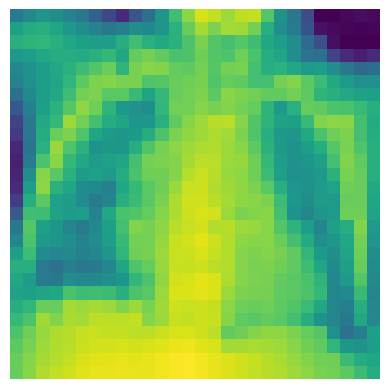

In [4]:
# Get the first image from the training set
first_image = dataset_train[0][0]

# Plot the image
plt.imshow(first_image)
plt.axis('off')
plt.show()


#### Preparing the data for training
- We are going to merge the two and use Keras validation parameter and then split again into training and validation subsets using the "validation_split" parameter whilst fitting the model.

In [5]:
dataset_train_val = dataset_train + dataset_val


- For training and testing we need the data to be in np.array form, so we extract from the list of tuples

In [6]:
train_val_images = np.array([np.array(dataset_train_val[n][0]) for n in range(len(dataset_train_val))])
train_val_labels = np.array([np.array(dataset_train_val[n][1]) for n in range(len(dataset_train_val))])
test_images = np.array([np.array(dataset_test[n][0]) for n in range(len(dataset_test))])
test_labels = np.array([np.array(dataset_test[n][1]) for n in range(len(dataset_test))])

- It can be seen that the labels are binary. This is important for selecting a loss function that is adecuate for binary output

In [7]:
test_labels[1]

array([0])

#### Thoughts on selecting a model

### Selecting a deep learning framework
I'm considering two of the most popular frameworks for deep learning, PyTorch and TensorFlow with Keras. Both have extensive support from the community and are widely used in real world projects. 

### Thougts on using Keras
- Keras is popular for being the simplest of the two. The definition of an architecture is straightforward and easy to build
- By being a high-level API of TensorFlow, the syntax of Keras simplify the details of the TensorFlow operations

#### Defining an initial architecture using Keras
- To start, the 28x28x1 images are passed to the input consisting of a fully dense layer of 64 nodes using relu actvation
- The output is then passed to hidden layer of 16 nodes, also using ReLu activation
- The final layer uses two nodes and Softmax activation. Softmax activation is ideal for categorical models <- For categorical cross entropy or Sparse categorical cross entropy
- Another option is for last layer to use a single node and Sigmoid activation <- for a binary classification

##### testing against a convolutional neural network architecture:
- We know change the architecture of the model to a Convolutional Neural Network. The input and hidden layers are now changed to a Conv2D type for convolutional processing for 2D images,
- The ReLu activation is kept in both  layer using ReLu activation and a 3x3 kernel size

#### Loss function
- For a yes/no output such as the labels in our dataset, a Binary Cross entropy should be adecuate


In [361]:
# To start, define the NN architecture using 64 neurons in the hidden layer
model_NN = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  
])

# Define the CNN architecture
model_CNN = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), padding='same', strides=1),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  # Assuming output classes are 2
])

Train both NN and CNN so that the loss and accuracy can be compared

In [362]:
# Compile the NN model
model_NN.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the NN model
training_NN = model_NN.fit(x=train_val_images, y=train_val_labels, epochs=26, batch_size=32, validation_split=0.2, verbose=0) 

In [363]:
# Compile the CNN model
model_CNN.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the CNN model
training_CNN = model_CNN.fit(x=train_val_images, y=train_val_labels, epochs=26, batch_size=32, validation_split=0.2, verbose=0) 

In [367]:
# Evaluate the NN and CNN models on the test set
y_eval_NN = model_NN.evaluate(test_images, test_labels, verbose=0)
display(f"Neural Network evaluation score: {y_eval_NN[1]}")
y_eval_CNN = model_CNN.evaluate(test_images, test_labels, verbose=0)
display(f"Convolutional NN evaluation score: {y_eval_CNN[1]}")

'Neural Network evaluation score: 0.8205128312110901'

'Convolutional NN evaluation score: 0.8317307829856873'

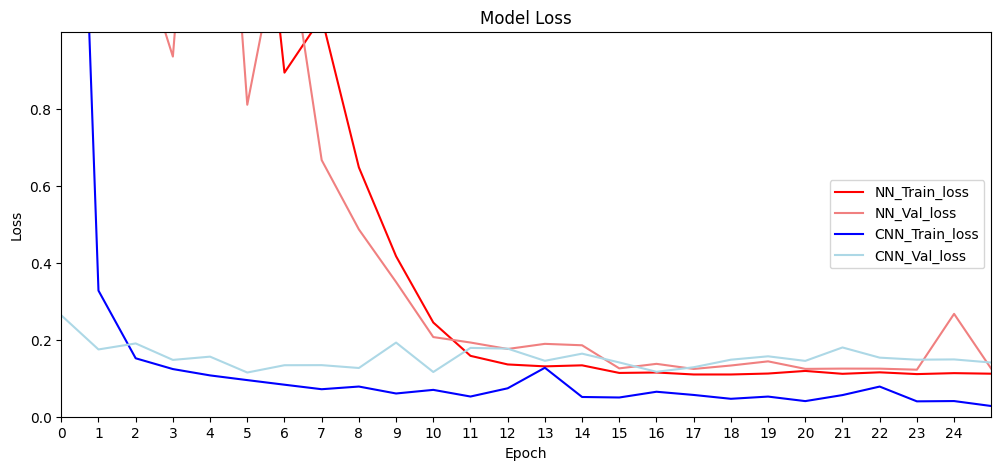

In [370]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(training_NN.history['loss'], label='NN_Train_loss', color='red')
if 'val_loss' in training_NN.history:
    ax.plot(training_NN.history['val_loss'], label='NN_Val_loss', color='lightcoral')
ax.plot(training_CNN.history['loss'], label='CNN_Train_loss', color='blue')
if 'val_loss' in training_CNN.history:
    ax.plot(training_CNN.history['val_loss'], label='CNN_Val_loss', color='lightblue')
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='right')
ax.set_xlim(0, 25)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, 25, 1))
ax.set_yticks(np.arange(0, 1, .2))
# set y scale to 0.2
plt.show()


In [295]:
test_predictions_NN = model_NN.predict(test_images)
test_predictions_CNN = model_CNN.predict(test_images)
test_predictions_CNN[0]

20/20 [==============================] - 0s 3ms/step


array([1.], dtype=float32)

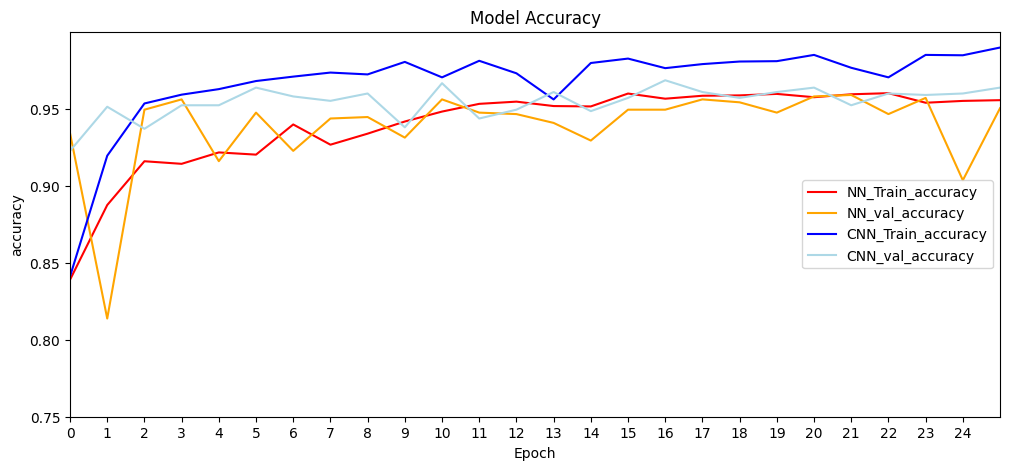

In [373]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(training_NN.history['accuracy'], label='NN_Train_accuracy', color='red')
if 'val_loss' in training_NN.history:
    ax.plot(training_NN.history['val_accuracy'], label='NN_val_accuracy', color='orange')
ax.plot(training_CNN.history['accuracy'], label='CNN_Train_accuracy', color='blue')
if 'val_loss' in training_CNN.history:
    ax.plot(training_CNN.history['val_accuracy'], label='CNN_val_accuracy', color='lightblue')
ax.set_title('Model Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.legend(loc='right')
ax.set_xlim(0, 25)
ax.set_ylim(.75, 1)
ax.set_xticks(np.arange(0, 25, 1))
ax.set_yticks(np.arange(.75, 1, .05))
# set y scale to 0.2
plt.show()

In [311]:
model_CNN.summary()

Model: "sequential_4257"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4451 (Conv2D)        (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2430 (MaxPool  (None, 14, 14, 64)       0         
 ing2D)                                                          
                                                                 
 flatten_2820 (Flatten)      (None, 12544)             0         
                                                                 
 dense_5451 (Dense)          (None, 1)                 12545     
                                                                 
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________________________


In [235]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
n_splits = 5

# Create an instance of StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Initialize a list to store the evaluation results
evaluation_results = []

# Perform cross-validation
for train_index, val_index in skf.split(train_val_images, train_val_labels):
    # Split the data into training and validation sets
    X_train, X_val = train_val_images[train_index], train_val_images[val_index]
    y_train, y_val = train_val_labels[train_index], train_val_labels[val_index]

    # Create a new instance of the model
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(2, activation='softmax')  
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # Train the model
    model.fit(x=X_train, y=y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on the validation set
    evaluation_results.append(model.evaluate(X_val, y_val))

# Calculate the average evaluation results
avg_loss = sum(result[0] for result in evaluation_results) / n_splits
avg_accuracy = sum(result[1] for result in evaluation_results) / n_splits

# Print the average evaluation results
print(f"Average Loss: {avg_loss}")
print(f"Average Accuracy: {avg_accuracy}")


33/33 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.9446
Average Loss: 0.5284165948629379
Average Accuracy: 0.948395049571991


In [92]:
train_val_images = np.array(train_val_images)
train_val_labels = np.array(train_val_labels)

#### Hyperparameter Tunning

In [312]:
def create_NN_model(num_layers=1, nodes=64, activation='relu', learning_rate=0.001):
    model = tf.keras.Sequential()
    for _ in range(num_layers):
        model.add(layers.Dense(nodes, activation=activation))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

def tune_NN_model(X, y, param_grid):
    model = KerasClassifier(build_fn=create_NN_model, verbose=0)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

param_grid = {'num_layers': [1, 2], 'activation': ['relu', 'tanh'], 'batch_size': [32, 64], 
          'epochs': [5, 7], 'learning_rate': [0.001]}

best_params, best_score = tune_NN_model(train_val_images, train_val_labels, param_grid)
print("Best Parameters:", best_params)
print("Best Score:", best_score)

/var/folders/x5/lk3vcxsd1ybc_z4fyxmp024h0000gn/T/ipykernel_1722/2720063970.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_NN_model, verbose=0)


Best Parameters: {'activation': 'relu', 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.001, 'num_layers': 1}
Best Score: 0.7421661734580993


##### Parameter tunning using CNNs:

In [313]:
def create_CNN_model(num_layers=1, nodes=64, activation='relu', learning_rate=0.001):
    model = tf.keras.Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(layers.Conv2D(nodes, activation=activation, kernel_size=(3, 3), input_shape=(28, 28, 1)))
        else:
            model.add(layers.Conv2D(nodes, activation=activation, kernel_size=(3, 3)))
    model.add(layers.MaxPool2D()),
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

def tune_model(X, y, param_grid):
    model = KerasClassifier(build_fn=create_CNN_model, verbose=0)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

param_grid = {'num_layers': [1, 2], 'activation': ['relu', 'leaky_relu'], 'batch_size': [32, 64], 
              'epochs': [5, 7, 10], 'learning_rate': [0.001]}

best_params, best_score = tune_model(train_val_images, train_val_labels, param_grid)
print("Best Parameters:", best_params)
print("Best Score:", best_score)


/var/folders/x5/lk3vcxsd1ybc_z4fyxmp024h0000gn/T/ipykernel_1722/1817851624.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_CNN_model, verbose=0)


Best Parameters: {'activation': 'relu', 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.001, 'num_layers': 1}
Best Score: 0.7421661734580993


- Now using pooling after each activation:

In [374]:

def create_CNN_pool_model(num_layers=1, nodes=64, activation='relu', learning_rate=0.001):
    model = tf.keras.Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(layers.Conv2D(nodes, activation=activation, kernel_size=(3, 3), input_shape=(28, 28, 1)))
            model.add(layers.MaxPool2D()),
        else:
            model.add(layers.Conv2D(nodes, activation=activation, kernel_size=(3, 3)))
            model.add(layers.MaxPool2D()),
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                #   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

def tune_CNN_pool_model(X, y, param_grid):
    model = KerasClassifier(build_fn=create_CNN_pool_model, verbose=0)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

In [375]:
param_grid = {'num_layers': [1, 2], 'nodes':[32,48], 'activation': ['relu', 'leaky_relu'], 'batch_size': [32], 
              'epochs': [5, 7, 9], 'learning_rate': [0.001]}

best_params, best_score = tune_model(train_val_images, train_val_labels, param_grid)
print("Best Parameters:", best_params)
print("Best Score:", best_score)

/var/folders/x5/lk3vcxsd1ybc_z4fyxmp024h0000gn/T/ipykernel_1722/1817851624.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_CNN_model, verbose=0)


Best Parameters: {'activation': 'relu', 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 32, 'num_layers': 1}
Best Score: 0.7421661734580993


TODO:
- pass validation data as a separate parameter during fit()
- Early stop: from tensorflow.keras.callbacks import EarlyStopping
    - Create callback and add it during fit
- Use train + Val for the final model training
- Experiment with different activations ['relu','leaky_relu', 'sigmoid', 'tanh']
- Try batch normalization?

#### Create a model with the optimal parameters:
- Using early stopping:

In [378]:
from tensorflow.keras.callbacks import EarlyStopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

best_model = create_CNN_pool_model(num_layers=1, nodes=32, activation='relu', learning_rate=0.001)
best_model.fit(train_val_images, train_val_labels, epochs=30, batch_size=32, callbacks=[monitor_val_acc], verbose=1, validation_split=0.2)
best_eval = best_model.evaluate(test_images, test_labels, verbose=1)
display(best_eval)

Epoch 1/30
131/131 [==============================] - 1s 6ms/step - loss: 2.2987 - accuracy: 0.8526 - val_loss: 0.2696 - val_accuracy: 0.9274
Epoch 2/30
131/131 [==============================] - 1s 6ms/step - loss: 0.2558 - accuracy: 0.9345 - val_loss: 0.2222 - val_accuracy: 0.9398
Epoch 3/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1990 - accuracy: 0.9467 - val_loss: 0.1719 - val_accuracy: 0.9475
Epoch 4/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1211 - accuracy: 0.9611 - val_loss: 0.1598 - val_accuracy: 0.9484
Epoch 5/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1332 - accuracy: 0.9589 - val_loss: 0.1403 - val_accuracy: 0.9599
Epoch 6/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0998 - accuracy: 0.9663 - val_loss: 0.1351 - val_accuracy: 0.9618
Epoch 7/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1143 - accuracy: 0.9634 - val_loss: 0.1596 - val_accuracy: 0.9542
Epoch 

[0.9378333687782288, 0.8253205418586731]

- Testing all epochs from 0 - 12:

In [387]:
all_evals = []
best_model = create_CNN_pool_model(num_layers=2, nodes=32, activation='relu', learning_rate=0.001)
for i in range(0, 12):
    best_model.fit(train_val_images, train_val_labels, epochs=i, batch_size=32, verbose=0)
    res = best_model.evaluate(test_images, test_labels, verbose=0)
    all_evals.append(res)
    display(f"== Score for {i} epochs: {res} ==")
display(all_evals)

'== Score for 0 epochs: [4.397148132324219, 0.37660256028175354] =='

'== Score for 1 epochs: [0.7317646741867065, 0.8028846383094788] =='

'== Score for 2 epochs: [0.5998052954673767, 0.8205128312110901] =='

'== Score for 3 epochs: [0.4239161014556885, 0.875] =='

'== Score for 4 epochs: [0.8380458354949951, 0.7996794581413269] =='

'== Score for 5 epochs: [0.6891554594039917, 0.8461538553237915] =='

'== Score for 6 epochs: [0.6883362531661987, 0.8733974099159241] =='

'== Score for 7 epochs: [0.5798804759979248, 0.8942307829856873] =='

'== Score for 8 epochs: [0.8284550905227661, 0.8653846383094788] =='

'== Score for 9 epochs: [1.276827096939087, 0.8125] =='

'== Score for 10 epochs: [1.4839102029800415, 0.8397436141967773] =='

'== Score for 11 epochs: [1.341635823249817, 0.8717948794364929] =='

[[4.397148132324219, 0.37660256028175354],
 [0.7317646741867065, 0.8028846383094788],
 [0.5998052954673767, 0.8205128312110901],
 [0.4239161014556885, 0.875],
 [0.8380458354949951, 0.7996794581413269],
 [0.6891554594039917, 0.8461538553237915],
 [0.6883362531661987, 0.8733974099159241],
 [0.5798804759979248, 0.8942307829856873],
 [0.8284550905227661, 0.8653846383094788],
 [1.276827096939087, 0.8125],
 [1.4839102029800415, 0.8397436141967773],
 [1.341635823249817, 0.8717948794364929]]

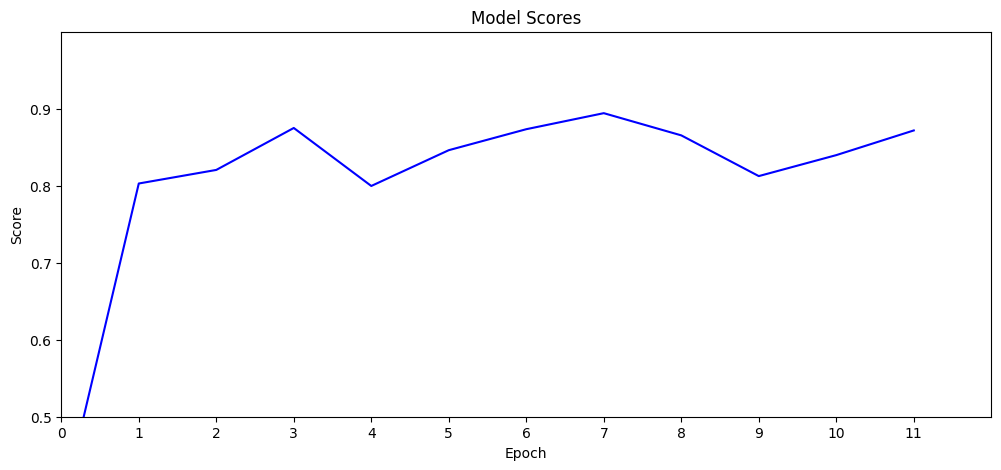

In [390]:
all_scores = [x[1] for x in all_evals]
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(all_scores, label='Score at Epoch', color='blue')
ax.set_title('Model Scores')
ax.set_ylabel('Score')
ax.set_xlabel('Epoch')
ax.set_xlim(0, 12)
ax.set_ylim(.5, 1)
ax.set_xticks(np.arange(0, 12, 1))
ax.set_yticks(np.arange(.5, 1, .1))
# set y scale to 0.2
plt.show()

Inspect the output of the first layer:

In [ ]:
# Obtain a reference to the outputs of the first layer
first_layer_output = model.layers[0].output

# Build a model using the model's input and the first layer output
first_layer_model = Model(inputs = model.layers[0].input, outputs = first_layer_output)

# Use this model to predict on X_test
activations = first_layer_model.predict(X_test)

# Plot the activations of first digit of X_test for the 15th filter
axs[0].matshow(activations[0,:,:,14], cmap = 'viridis')

# Do the same but for the 18th filter now
axs[1].matshow(activations[0,:,:,18], cmap = 'viridis')
plt.show()

### PyTorch: